In [28]:
#%pip install --upgrade package_name

In [ ]:
# data manipulation
import numpy as np
import pandas as pd

# models
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# visualizations
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# tests
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, ccf
from statsmodels.stats.stattools import durbin_watson


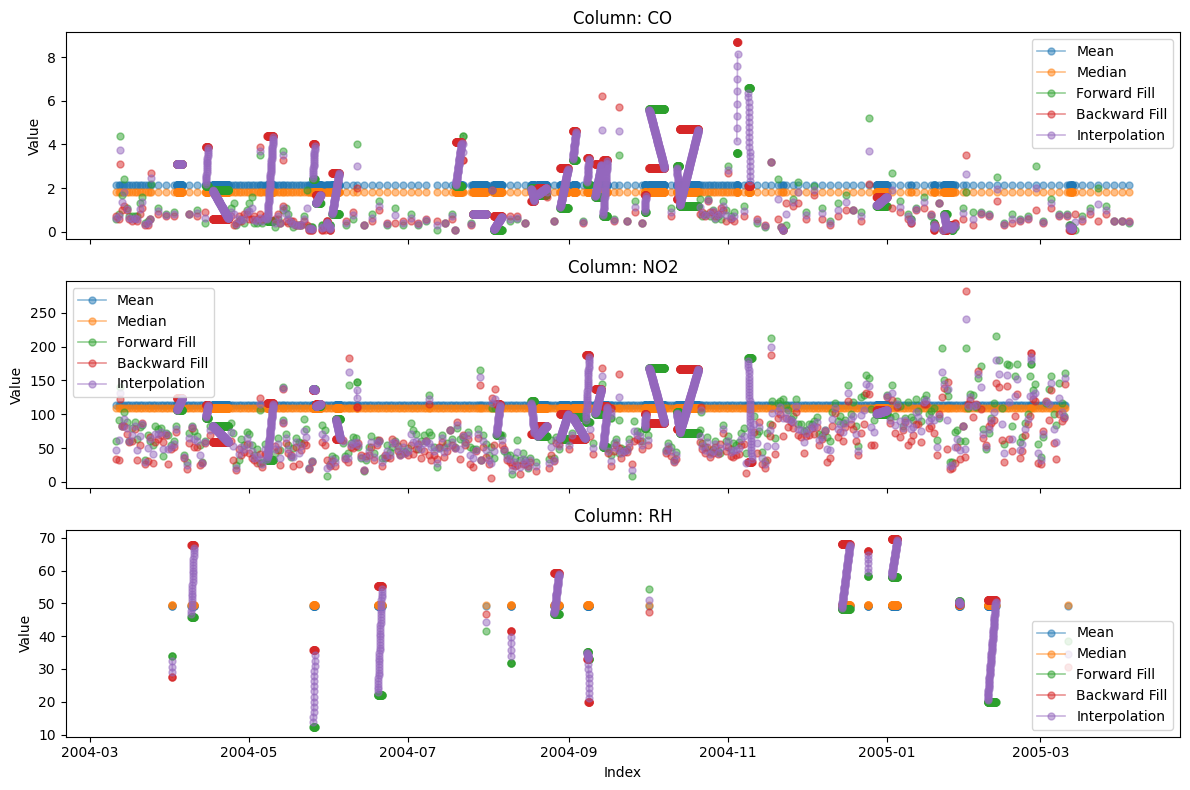

In [30]:
#  Load and preprocess the data
data = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',')

#print(data.shape)  #  (9471, 17)

#print(data.head(3))
#          Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)      T    RH      AH  Unnamed: 15  Unnamed: 16  
# 0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   1046.0           166.0        1056.0    113.0        1692.0       1268.0   13.6  48.9  0.7578          NaN          NaN  
# 1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   955.0            103.0        1174.0     92.0        1559.0        972.0   13.3  47.7  0.7255          NaN          NaN 
# 2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   939.0            131.0        1140.0    114.0        1555.0       1074.0   11.9  54.0  0.7502          NaN          NaN 

#  Check for missing values
#print(data.isnull().sum())
#  Date              114
#  Time              114
#  CO(GT)            114
#  PT08.S1(CO)       114
#  NMHC(GT)          114
#  C6H6(GT)          114
#  PT08.S2(NMHC)     114
#  NOx(GT)           114
#  PT08.S3(NOx)      114
#  NO2(GT)           114
#  PT08.S4(NO2)      114
#  PT08.S5(O3)       114
#  T                 114
#  RH                114
#  AH                114
#  Unnamed: 15      9471
#  Unnamed: 16      9471
#  dtype: int64

#  Convert Date and Time columns to datetime and set Datetime as index
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S')
data.set_index('Datetime', inplace=True)

#  select only the columns of interest and drop missing values
data = data[['CO(GT)', 'NO2(GT)', 'RH']].dropna()
data.columns = ['CO', 'NO2', 'RH']  # Rename columns for simplicity
data = data.asfreq('h')  # Set frequency to hourly

#print(data.shape)
#  (9357, 3) (9471-9357 = 114 NaNs dropped, the bottom rows of the file)

#  Checking how many -200 values are in the dataset 
#print("-200 values:\n",data[data == -200].count())
#  -200 values:
#  Date          0
#  Time          0
#  CO         1683
#  NO2        1642
#  RH          366
#  dtype: int64

data.replace(-200, np.nan, inplace=True)

#  Exploring exclusion method: drop rows with missing values
#data.dropna(inplace=True)
#print("shape after dropping NaN:\n",data.shape)
#  = (6941, 3)
#  2416 rows were dropped (9357 - 6941)
#  resulting in 2416/9357*100 = 25.8% of the data being dropped
#  this is a significant amount of data to be dropped
#  so we will explore other options to handle missing values

#  Impute options:
#  1. fill with mean
#  2. fill with median
#  3. fill with forward fill
#  4. fill with backward fill
#  5. fill with interpolation


#  1: Impute missing values with mean
df_mean = data.fillna(data.mean())

#  describe the data
#print("\nImpute_Mean:\n",df_mean.describe())
#  Impute_Mean:
#                  CO          NO2           RH
#  count  9357.000000  9357.000000  9357.000000
#  mean      2.152750   113.091251    49.234201
#  std       1.316068    43.920954    16.974801
#  min       0.100000     2.000000     9.200000
#  25%       1.200000    86.000000    36.600000
#  50%       2.152750   113.091251    49.234201
#  75%       2.600000   133.000000    61.900000
#  max      11.900000   340.000000    88.700000

#  2: Impute missing values with median
df_median = data.fillna(data.median())

#  describe the data
#print("\nImpute_Median\n",df_median.describe())
#  Impute_Median
#                  CO          NO2           RH
#  count  9357.000000  9357.000000  9357.000000
#  mean      2.089302   112.373303    49.248509
#  std       1.323024    43.948519    16.974949
#  min       0.100000     2.000000     9.200000
#  25%       1.200000    86.000000    36.600000
#  50%       1.800000   109.000000    49.600000
#  75%       2.600000   133.000000    61.900000
#  max      11.900000   340.000000    88.700000

#  3: Impute missing values with forward fill
df_ffill = data.ffill()

#  describe the data
#print("\nImpute_ForwardFill\n",df_ffill.describe())
#  Impute_ForwardFill
#                  CO          NO2           RH
#  count  9357.000000  9357.000000  9357.000000
#  mean      2.082195   109.414877    48.817431
#  std       1.469801    47.221662    17.354326
#  min       0.100000     2.000000     9.200000
#  25%       1.000000    73.000000    35.400000
#  50%       1.700000   102.000000    48.900000
#  75%       2.800000   137.000000    61.900000
#  max      11.900000   340.000000    88.700000

#  4: Impute missing values with backward fill
df_bfill = data.bfill()

#  describe the data
#print("\nImpute_BackwardFill\n",df_bfill.describe())
#  Impute_BackwardFill
#                  CO          NO2           RH
#  count  9357.000000  9357.000000  9357.000000
#  mean      2.179010   109.849311    49.565341
#  std       1.470994    47.635033    17.214838
#  min       0.100000     2.000000     9.200000
#  25%       1.000000    74.000000    36.300000
#  50%       1.900000   106.000000    50.200000
#  75%       3.000000   138.000000    62.900000
#  max      11.900000   340.000000    88.700000

#  5: Impute missing values with interpolation
df_interpolate = data.interpolate()

#  describe the data
#print("\nImpute_Interpolate\n",df_interpolate.describe())
#  Impute_Interpolate
#                  CO          NO2           RH
#  count  9357.000000  9357.000000  9357.000000
#  mean      2.130603   109.632094    49.191386
#  std       1.431736    46.462311    17.194506
#  min       0.100000     2.000000     9.200000
#  25%       1.100000    76.000000    35.800000
#  50%       1.800000   104.917526    49.600000
#  75%       2.900000   136.314685    62.300000
#  max      11.900000   340.000000    88.700000


#  Plotting the differences between the imputation methods
def plot_imputed_values():
    # Identify locations of missing values
    missing_mask = data.isna()

    # Extract values for missing positions
    imputed_values = {
        "Mean": df_mean[missing_mask],
        "Median": df_median[missing_mask],
        "Forward Fill": df_ffill[missing_mask],
        "Backward Fill": df_bfill[missing_mask],
        "Interpolation": df_interpolate[missing_mask]
    }

    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    for i, col in enumerate(data.columns):
        for method, df in imputed_values.items():
            axes[i].plot(
                df.index, df[col], 
                marker='o', markersize=5, alpha=0.5,
                linestyle='-', linewidth=1.2,
                label=method
            )
        axes[i].set_title(f"Column: {col}")
        axes[i].legend()
        axes[i].set_ylabel("Value")

    axes[-1].set_xlabel("Index")
    plt.tight_layout()
    plt.show()

plot_imputed_values()


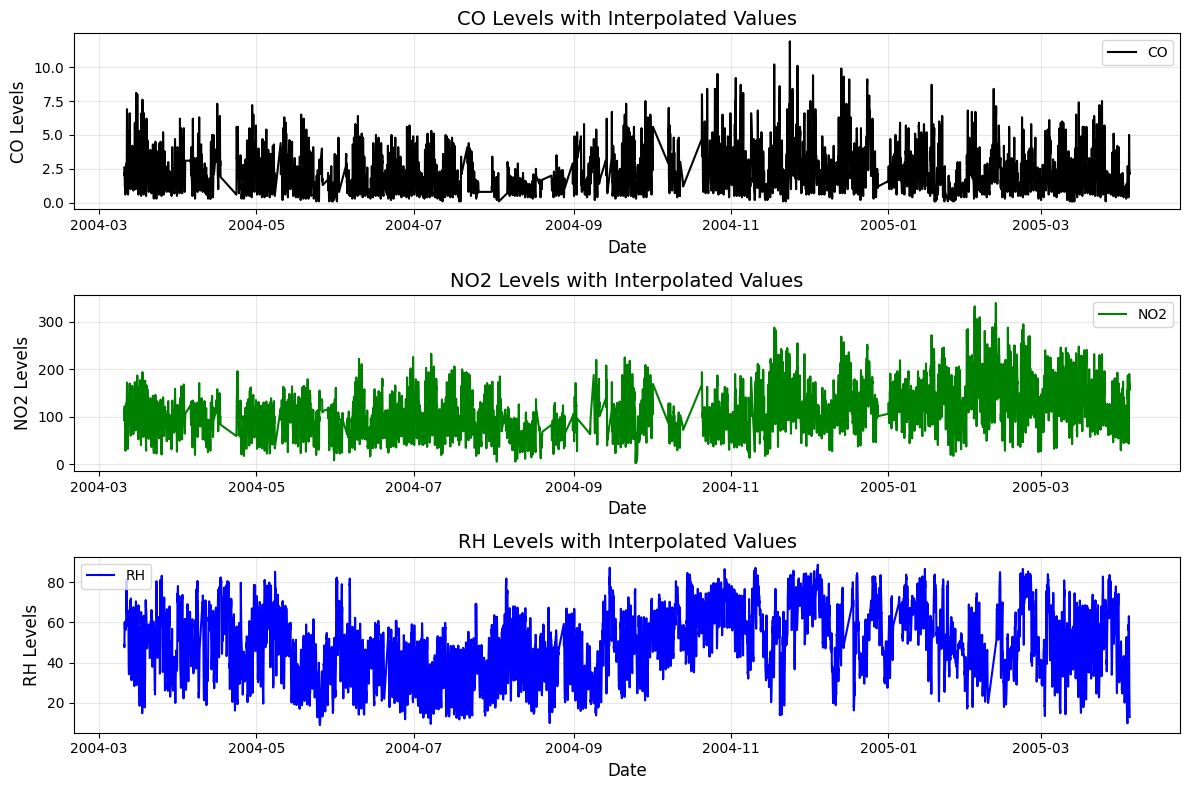

In [ ]:
# missing data handled with interpolation


data = df_interpolate
#print("\nMissing_data:\n",data.isnull().sum())
#  Missing_data:
#  CO     0
#  NO2    0
#  RH     0
#  dtype: int64


#  Plotting the data with interpolated values
def plot_interpolated_values():
    columns = ['CO', 'NO2', 'RH']
    colors = ['black', 'green', 'blue']
    titles = ['CO Levels', 'NO2 Levels', 'RH Levels']

    fig, axes = plt.subplots(len(columns), 1, figsize=(12, 8))
    for i, (col, color, title) in enumerate(zip(columns, colors, titles)):
        axes[i].plot(data.index, data[col], label=col, color=color)
        axes[i].set_title(f'{title} with Interpolated Values', fontsize=14)
        axes[i].set_xlabel('Date', fontsize=12)
        axes[i].set_ylabel(f'{col} Levels', fontsize=12)
        axes[i].grid(alpha=0.3)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

plot_interpolated_values()


In [ ]:
# Stationarity test functions (ADF and KPSS)
def check_stationarity(series, col):
    adf_p_value = adfuller(series)[1]
    kpss_p_value = kpss(series, regression='c')[1]
    print(f"\n--- {col} ---")
    print("ADF Test:", adf_p_value < 0.05)  # p-value < 0.05 = Stationary
    print("KPSS Test:", kpss_p_value > 0.05)  # p-value > 0.05 = Stationary

# Check stationarity for each column
for col in data.columns:
    check_stationarity(data[col], col)

# ADF = all true, KPSS = all false


# log transformation
df_log = np.log(data).diff().dropna() # First order differencing since KPSS test is not giving true

for col in df_log.columns:
    check_stationarity(df_log[col], col)

# ADF = all true, KPSS = all true


C:\Users\bergl\AppData\Local\Temp\ipykernel_23712\3003977981.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(series, regression='c')[1]



--- CO ---
ADF Test: True
KPSS Test: False


C:\Users\bergl\AppData\Local\Temp\ipykernel_23712\3003977981.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(series, regression='c')[1]



--- NO2 ---
ADF Test: True
KPSS Test: False


C:\Users\bergl\AppData\Local\Temp\ipykernel_23712\3003977981.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(series, regression='c')[1]



--- RH ---
ADF Test: True
KPSS Test: False


C:\Users\bergl\AppData\Local\Temp\ipykernel_23712\3003977981.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(series, regression='c')[1]



--- CO ---
ADF Test: True
KPSS Test: True


C:\Users\bergl\AppData\Local\Temp\ipykernel_23712\3003977981.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(series, regression='c')[1]



--- NO2 ---
ADF Test: True
KPSS Test: True

--- RH ---
ADF Test: True
KPSS Test: True


C:\Users\bergl\AppData\Local\Temp\ipykernel_23712\3003977981.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(series, regression='c')[1]



Testing Granger Causality: CO -> NO2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=150.5448, p=0.0000  , df_denom=9352, df_num=1
ssr based chi2 test:   chi2=150.5931, p=0.0000  , df=1
likelihood ratio test: chi2=149.3938, p=0.0000  , df=1
parameter F test:         F=150.5448, p=0.0000  , df_denom=9352, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=131.7613, p=0.0000  , df_denom=9349, df_num=2
ssr based chi2 test:   chi2=263.6635, p=0.0000  , df=2
likelihood ratio test: chi2=260.0159, p=0.0000  , df=2
parameter F test:         F=131.7613, p=0.0000  , df_denom=9349, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=106.7444, p=0.0000  , df_denom=9346, df_num=3
ssr based chi2 test:   chi2=320.4730, p=0.0000  , df=3
likelihood ratio test: chi2=315.1049, p=0.0000  , df=3
parameter F test:         F=106.7444, p=0.0000  , df_denom=9346, df_num=3

Granger Causality
number of lags (no zero) 4
ssr 

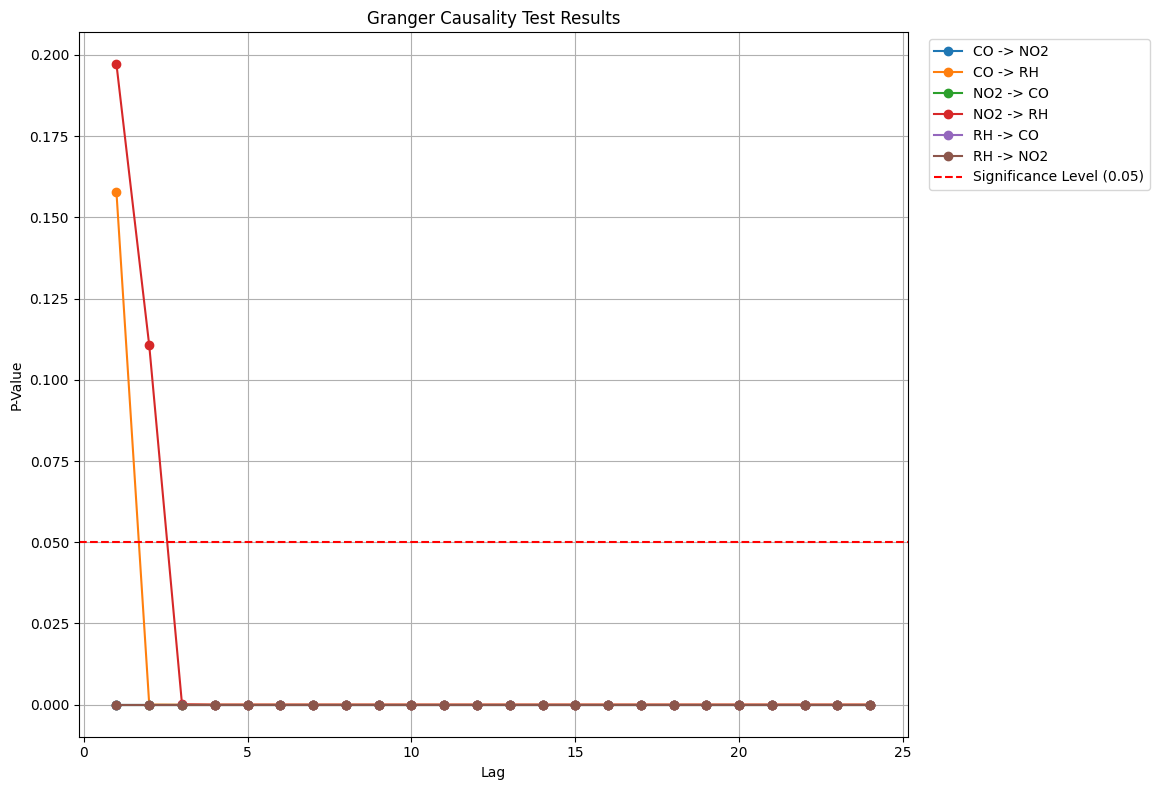

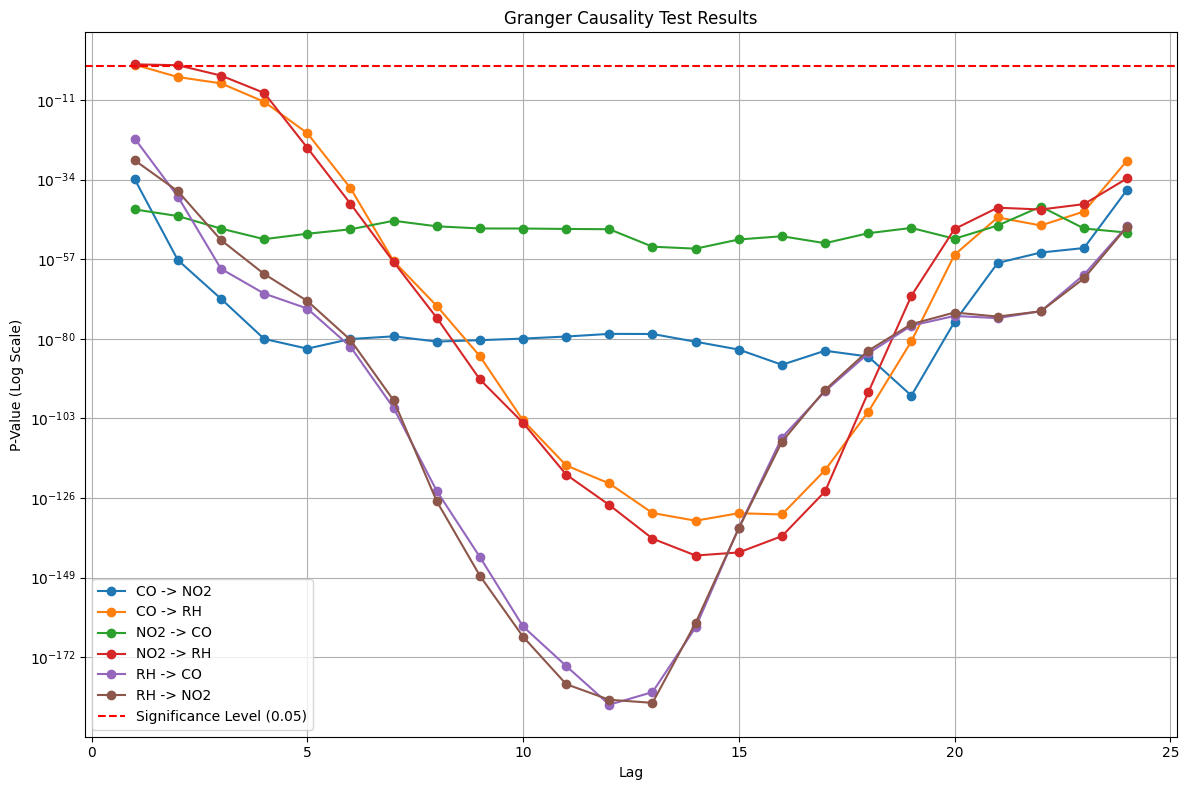

In [33]:
# Granger Causality Test Function
def granger_causality(d, max_lag=24):
    """
    Perform Granger Causality tests between all pairs of columns in the dataset.
    Args:
        d (DataFrame): DataFrame containing time series data.
        max_lag (int): Maximum number of lags to test for causality.

    Returns:
        dict: A nested dictionary with p-values for all lag levels for each causal relationship.
    """
    results = {}
    for col1 in d.columns:
        for col2 in d.columns:
            if col1 != col2:
                print(f"\nTesting Granger Causality: {col1} -> {col2}")
                test_result = grangercausalitytests(d[[col1, col2]], max_lag)

                # Extract p-values for each lag
                p_values = {}
                for lag in range(1, max_lag + 1):
                    p_value = test_result[lag][0]['ssr_chi2test'][1]  # Extract p-value
                    p_values[lag] = p_value
                results[f'{col1} -> {col2}'] = p_values
    return results

# Visualization Function
def plot_granger_results(granger_results, significance_level=0.05):
    """
    Plot the p-values for Granger Causality tests for all relationships.

    Args:
        granger_results (dict): Nested dictionary with p-values.
        significance_level (float): Threshold for significance.
    """
    plt.figure(figsize=(12, 8))

    for relation, p_values in granger_results.items():
        lags = list(p_values.keys())
        p_vals = list(p_values.values())
        plt.plot(lags, p_vals, marker='o', linestyle='-', label=relation)

    plt.axhline(y=significance_level, color='r', linestyle='--', label='Significance Level (0.05)')
    plt.xlabel('Lag')
    plt.ylabel('P-Value')
    plt.title('Granger Causality Test Results')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot Granger Causality Test Results for all relationships
def plot_granger_results_version_2(granger_results):
    """
    Dynamically plots Granger causality p-values for each relationship in granger_results.

    Parameters:
        granger_results (dict): Dictionary containing p-values for Granger causality tests.
                                Keys are 'col1 -> col2' strings, and values are dicts {lag: p-value}.
    """
    plt.figure(figsize=(12, 8))

    # Iterate through each relationship in the granger_results dictionary
    for relation, p_values in granger_results.items():
        # Extract lags (x-axis) and p-values (y-axis)
        lags = list(p_values.keys())
        p_vals = list(p_values.values())

        # Plot the p-values for the current relationship
        plt.plot(lags, p_vals, marker='o', linestyle='-', label=relation)

    # Plot formatting
    plt.yscale('log')  # Log scale for p-values to handle very small values
    plt.xlabel('Lag')
    plt.ylabel('P-Value (Log Scale)')
    plt.title('Granger Causality Test Results')
    plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')  # Threshold line
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

granger_results = granger_causality(df_log, max_lag=24)
plot_granger_results(granger_results, significance_level=0.05)
plot_granger_results_version_2(granger_results)


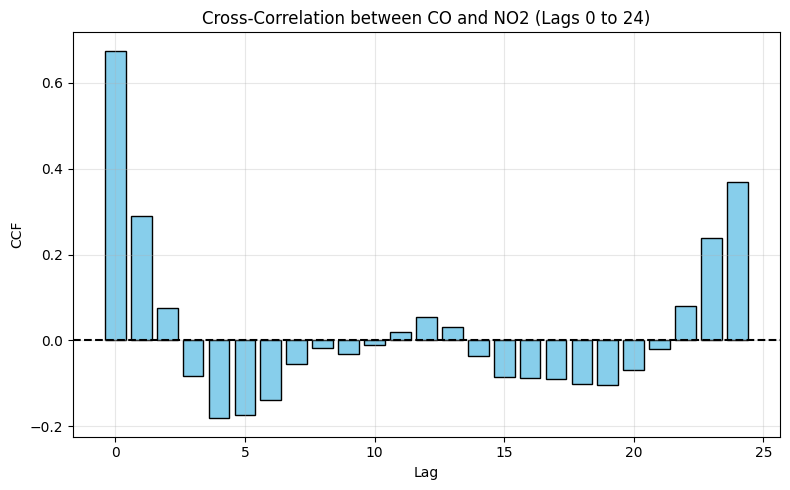

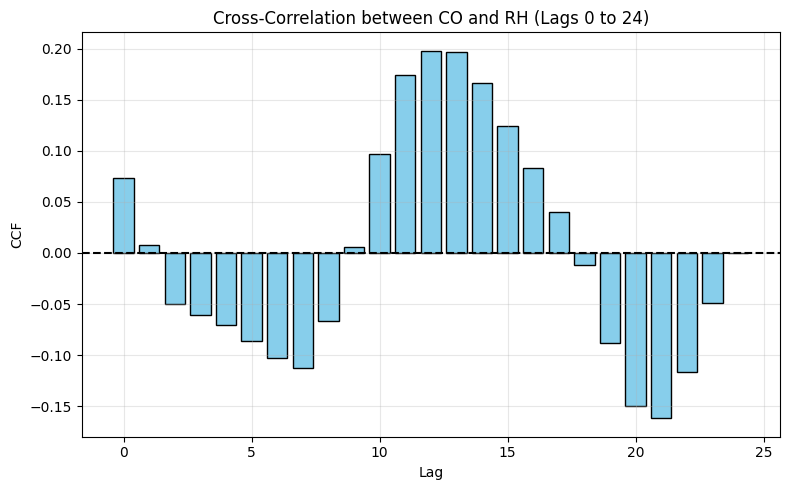

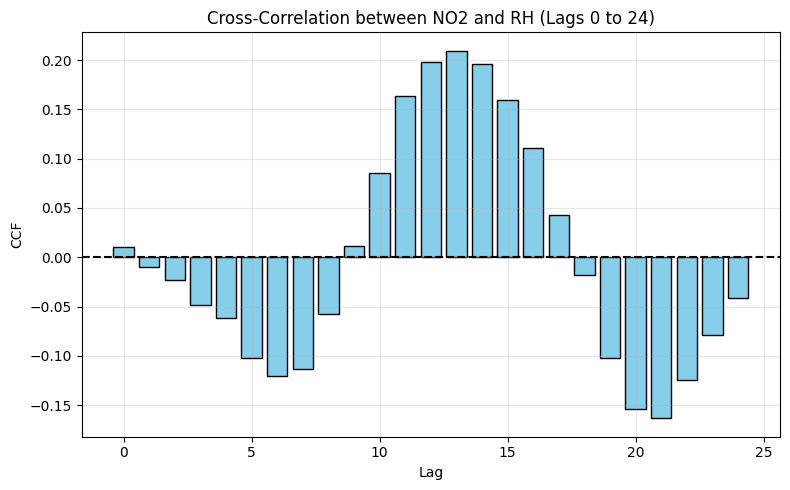

In [34]:
# Cross-correlation between CO, NO2, and RH

# List of variable pairs
variables = [('CO', 'NO2'), ('CO', 'RH'), ('NO2', 'RH')]
max_lag = 24

# Iterate through each pair and calculate CCF
for var1, var2 in variables:
    # Calculate cross-correlation 
    ccf_values = ccf(df_log[var1], df_log[var2], adjusted=False)[:max_lag + 1]
    
    # Generate lags from 0 to max_lag
    lags = list(range(0, max_lag + 1))

    # Plot CCF as a bar plot
    plt.figure(figsize=(8, 5))
    plt.bar(lags, ccf_values, color='skyblue', edgecolor='k')
    plt.title(f'Cross-Correlation between {var1} and {var2} (Lags 0 to {max_lag})')
    plt.xlabel('Lag')
    plt.ylabel('CCF')
    plt.axhline(y=0, color='black', linestyle='--')  # Zero line for reference
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


Train Set Size: 9332, Test Set Size: 24
  VAR Order Selection (* highlights the minimums)  
        AIC         BIC         FPE         HQIC   
---------------------------------------------------
0        -10.41      -10.41   3.012e-05      -10.41
1        -10.81      -10.81   2.010e-05      -10.81
2        -10.87      -10.85   1.911e-05      -10.86
3        -10.92      -10.90   1.810e-05      -10.91
4        -10.96      -10.93   1.732e-05      -10.95
5        -10.99      -10.96   1.682e-05      -10.98
6        -11.03      -10.99   1.618e-05      -11.02
7        -11.07      -11.02   1.552e-05      -11.06
8        -11.12      -11.07   1.476e-05      -11.10
9        -11.16      -11.10   1.417e-05      -11.14
10       -11.20      -11.13   1.370e-05      -11.17
11       -11.22      -11.14   1.345e-05      -11.19
12       -11.23      -11.15   1.323e-05      -11.20
13       -11.26      -11.17   1.288e-05      -11.23
14       -11.28      -11.18   1.258e-05      -11.25
15       -11.30      -11

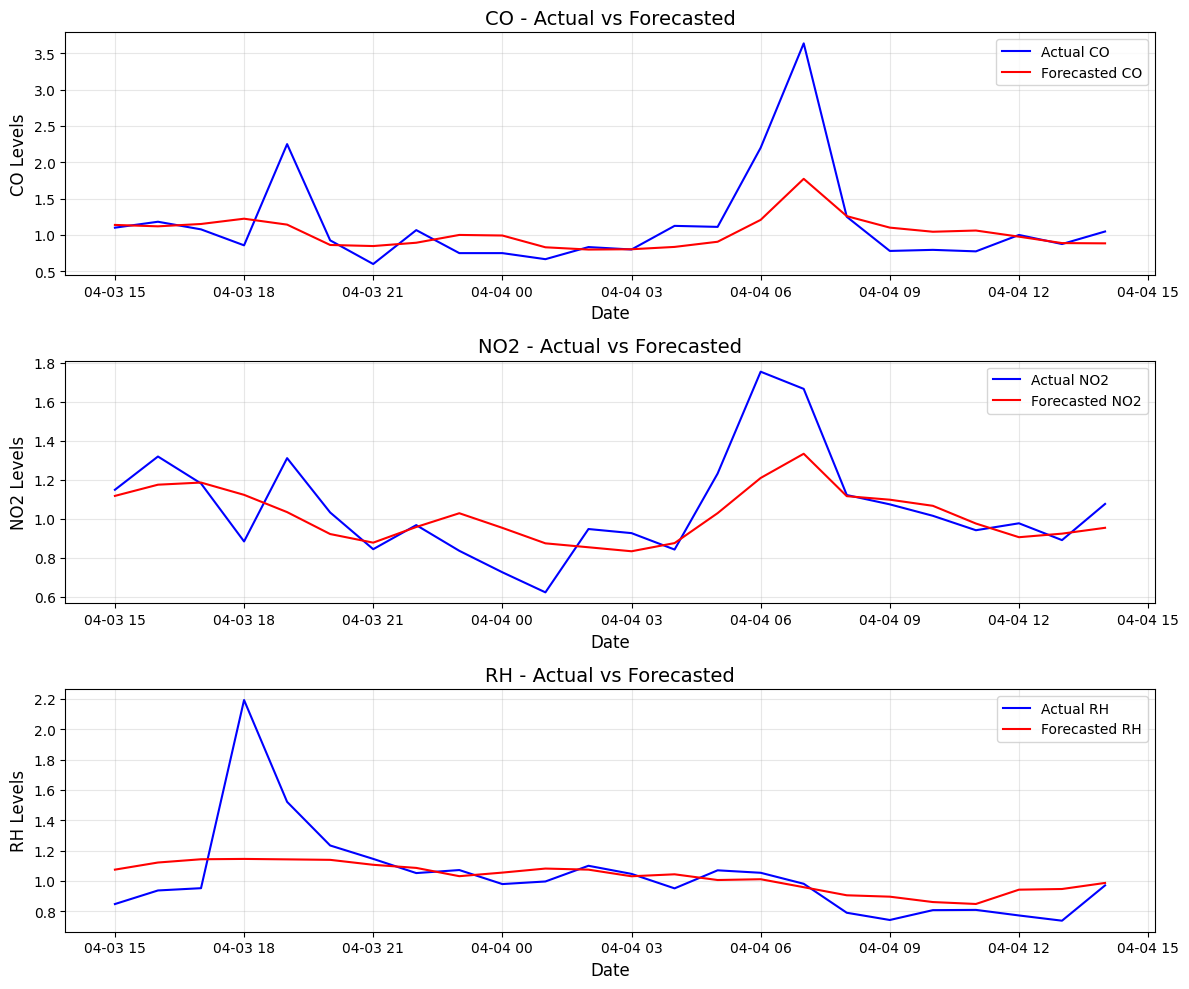

In [35]:
# VAR Model 


# Split into training and test sets
train = df_log[:-24]  # All but the last 24 values for training
test = df_log[-24:]   # Last 24 values for testing

# Check the size of the training and test sets
print(f"Train Set Size: {len(train)}, Test Set Size: {len(test)}")

# Determine the optimal lag using AIC or BIC
model = VAR(train)

# Select the optimal lag order using information criteria
lag_order = model.select_order(maxlags=168)  # Test up to a week lags
print(lag_order.summary())  # Prints AIC, BIC, FPE, HQIC values for each lag

# Extract the optimal lag based on AIC (can change to BIC, HQIC, etc.)
optimal_lag = lag_order.aic
print(f"Optimal Lag Order (AIC): {optimal_lag}")

# Fit the VAR model with the optimal lag
var_model = model.fit(optimal_lag)

# Forecast the VAR model
forecast = var_model.forecast(train.values[-optimal_lag:], steps=24)

# Convert the forecast back to a DataFrame (log values)
forecast_df = pd.DataFrame(forecast, index=test.index, columns=df_log.columns)

# Reconstruct the original scale by exponentiating (reverse the log transformation)
forecast_original = np.exp(forecast_df)

# Exponentiate the test data for comparison (in the original scale)
test_original = np.exp(test)

# Plot actual vs forecasted values for each variable in their original scale
fig, axes = plt.subplots(len(df_log.columns), 1, figsize=(12, 10))
for i, col in enumerate(df_log.columns):
    axes[i].plot(test_original.index, test_original[col], label=f'Actual {col}', color='blue')
    axes[i].plot(forecast_original.index, forecast_original[col], label=f'Forecasted {col}', color='red')
    axes[i].set_title(f'{col} - Actual vs Forecasted', fontsize=14)
    axes[i].set_xlabel('Date', fontsize=12)
    axes[i].set_ylabel(f'{col} Levels', fontsize=12)
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [36]:
# Evaluate the forecast using MAE, MSE, and RMSE

def evaluate_forecast(test, forecast):
    """
    Evaluate the forecast using MAE, MSE, and RMSE for each variable.
    Args:
        test (DataFrame): Actual test data.
        forecast (DataFrame): Forecasted data.
    Returns:
        DataFrame: MAE, MSE, RMSE values for each variable.
    """
    mae_values = {}
    mse_values = {}
    rmse_values = {}

    # Ensure that the forecast and test sets are aligned (same columns)
    for col in test.columns:
        if col not in forecast.columns:
            print(f"Warning: Column {col} is missing in forecast data")
            continue

        mae = mean_absolute_error(test[col], forecast[col])  # MAE calculation
        mse = mean_squared_error(test[col], forecast[col])   # MSE calculation
        rmse = np.sqrt(mse)  # RMSE is the square root of MSE
        
        mae_values[col] = mae
        mse_values[col] = mse
        rmse_values[col] = rmse
    
    # Return as a DataFrame for easy comparison
    return pd.DataFrame({'MAE': mae_values, 'MSE': mse_values, 'RMSE': rmse_values})

# Ensure original scale for RMSE calculation if using log-transformed data
test_original = np.exp(test)  # Exponentiate to original scale since log-transformed

# Ensure forecast is a DataFrame with proper index
forecast_original = pd.DataFrame(np.exp(forecast), index=test.index, columns=test.columns)

# Check that the forecast and test data have the same columns and index
if not np.array_equal(test_original.index, forecast_original.index):
    print("Error: The indices of the forecast and test sets do not match!")
else:
    print("Indices match. Proceeding with evaluation.")

# Calculate MAE, MSE, and RMSE for each variable
metrics = evaluate_forecast(test_original, forecast_original)
print("\nEvaluation Metrics (MAE, MSE, RMSE) for each variable:")
print(metrics)

# Optionally, calculate overall metrics across all variables
overall_mae = metrics['MAE'].mean()
overall_mse = metrics['MSE'].mean()
overall_rmse = metrics['RMSE'].mean()

print(f"\nOverall MAE: {overall_mae}")
print(f"Overall MSE: {overall_mse}")
print(f"Overall RMSE: {overall_rmse}")





res = durbin_watson(var_model.resid)

for col, val in zip(df_log.columns, res):
    print(f"Durbin-Watson Statistic for {col}: {val}")


Indices match. Proceeding with evaluation.

Evaluation Metrics (MAE, MSE, RMSE) for each variable:
          MAE       MSE      RMSE
CO   0.301852  0.269883  0.519503
NO2  0.131811  0.033899  0.184117
RH   0.142300  0.063244  0.251484

Overall MAE: 0.19198751577287518
Overall MSE: 0.12234225124985237
Overall RMSE: 0.31836810823974737
Durbin-Watson Statistic for CO: 2.005471463717426
Durbin-Watson Statistic for NO2: 2.0026617001966462
Durbin-Watson Statistic for RH: 1.9979009981705411


Train Set Size: 9332, Test Set Size: 24


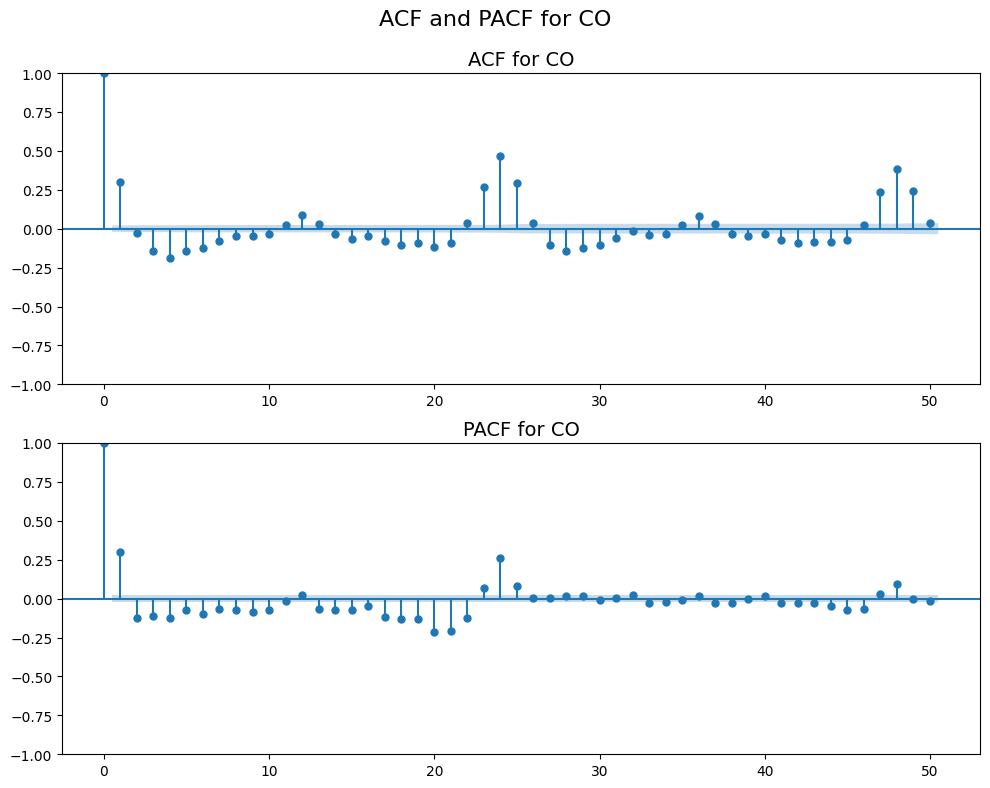

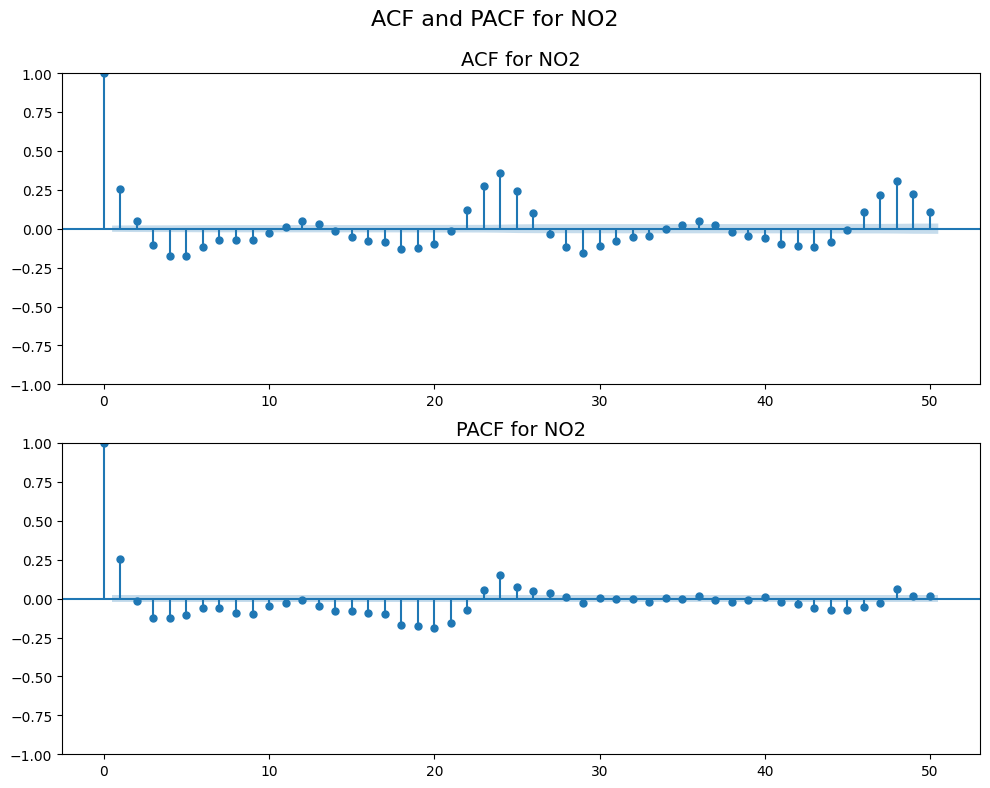

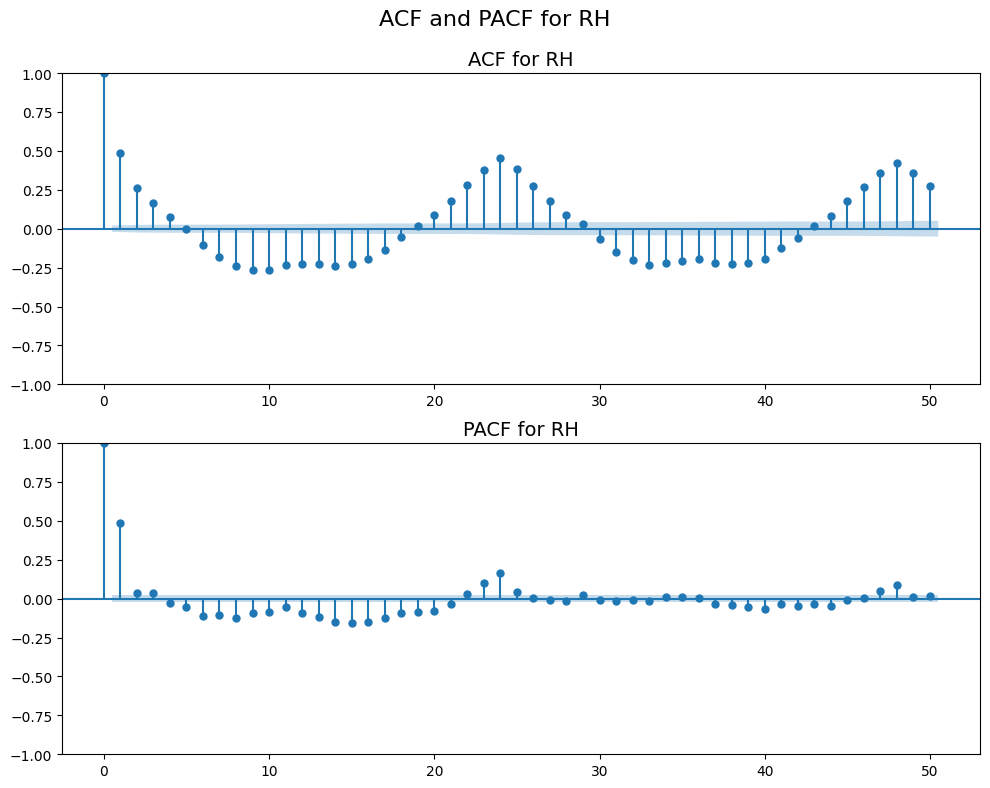

Processing Variable: CO
Variable: CO
MAE: 0.360, MSE: 0.448, RMSE: 0.669

Processing Variable: NO2
Variable: NO2
MAE: 0.188, MSE: 0.070, RMSE: 0.265

Processing Variable: RH


c:\Users\bergl\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Variable: RH
MAE: 0.174, MSE: 0.089, RMSE: 0.298



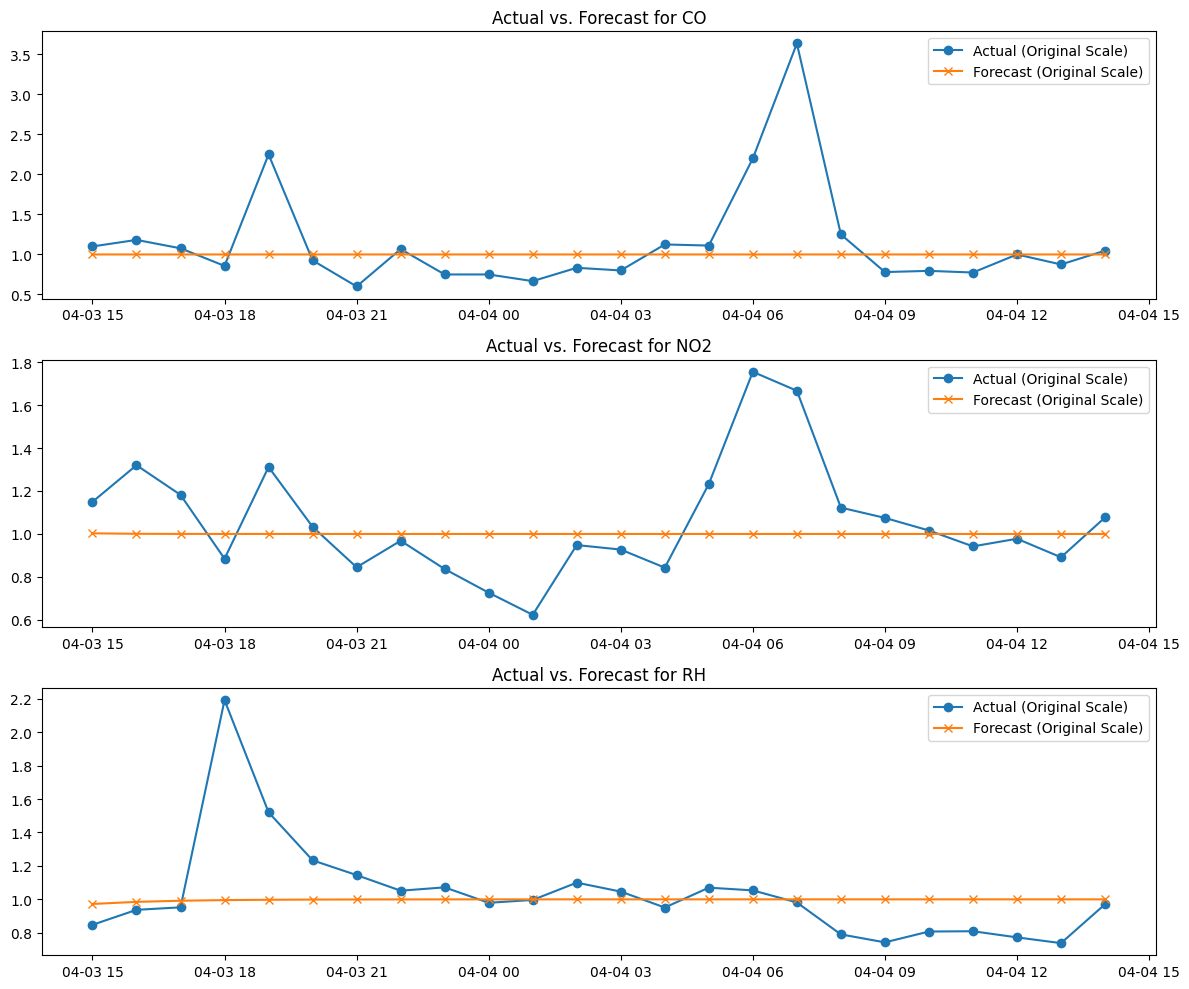

In [ ]:
# ARIMA model

# Split into training and test sets
train_arima = df_log[:-24]  # All but the last 24 values for training
test_arima = df_log[-24:]   # Last 24 values for testing

# Check the size of the training and test sets
print(f"Train Set Size: {len(train_arima)}, Test Set Size: {len(test_arima)}")

# Plot ACF and PACF 
for col in df_log.columns:
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot ACF
    plot_acf(df_log[col], lags=50, ax=axes[0])
    axes[0].set_title(f'ACF for {col}', fontsize=14)
    
    # Plot PACF
    plot_pacf(df_log[col], lags=50, ax=axes[1])
    axes[1].set_title(f'PACF for {col}', fontsize=14)
    
    plt.tight_layout()
    plt.suptitle(f'ACF and PACF for {col}', fontsize=16)
    plt.subplots_adjust(top=0.9)  # Adjust the space to fit the title
    plt.show()



# The data has been differenced once with log, so we can use d=1 in the ARIMA model.
# p, d, q 
# p and q values have been determined from the ACF and PACF plots:

# CO:
# PACF: Shows a strong partial autocorrelation at lag 1 that suggests p=1.
# ACF: Significant autocorrelations at a few initial lags, with a gradual decay. This suggests 
# q=1 or possibly q=2.
# model for CO: ARIMA(1, 1, 1)

# NO2:
# PACF: Strong partial autocorrelation at lag 1, with some smaller values beyond this. 
# p=1 seems appropriate.
# ACF: Gradual decay similar to CO. q=1 or possibly q=2.
# model for NO2: ARIMA(1, 1, 1)

# RH (Relative Humidity):
# PACF: Partial autocorrelation is significant at lag 1. p=1.
# ACF: There is more structure with oscillations. This may suggest higher 
# q values, potentially q=2 or q=3.
# model for RH: ARIMA(1, 1, 2)


In [ ]:
# ARIMA model

# # Splitting data
train_arima = df_log[:-24]  # Training set
test_arima = df_log[-24:]   # Test set

# Initialize results dictionary for storing forecasts and metrics
results = {}

# Define ARIMA model configurations
arima_configs = {
    "CO": (1, 1, 1),
    "NO2": (1, 1, 1),
    "RH": (1, 1, 2)
}

# Fit models and forecast
for var, order in arima_configs.items():
    print(f"Processing Variable: {var}")
    
    # Fit ARIMA model
    model_a = ARIMA(train_arima[var], order=order)
    model_fit = model_a.fit()  # Fixed model variable name
    
    # Forecast
    forecast_log = model_fit.forecast(steps=24)  # Forecast 24 steps ahead
    forecast_original = np.exp(forecast_log)    # Revert forecast to original scale
    actual_original = np.exp(test_arima[var])   # Revert test data to original scale

    # Calculate evaluation metrics
    mae = mean_absolute_error(actual_original, forecast_original)
    mse = mean_squared_error(actual_original, forecast_original)
    rmse = np.sqrt(mse)

    # Store results
    results[var] = {
        "forecast": forecast_original,
        "mae": mae,
        "mse": mse,
        "rmse": rmse
    }

    # Print evaluation metrics
    print(f"Variable: {var}")
    print(f"MAE: {mae:.3f}, MSE: {mse:.3f}, RMSE: {rmse:.3f}\n")

# Plot results
plt.figure(figsize=(12, 10))
for i, var in enumerate(arima_configs.keys()):
    plt.subplot(3, 1, i + 1)
    plt.plot(np.exp(test_arima[var]), label="Actual (Original Scale)", marker="o")
    plt.plot(results[var]["forecast"], label="Forecast (Original Scale)", marker="x")
    plt.title(f"Actual vs. Forecast for {var}")
    plt.legend()
    plt.tight_layout()

plt.show()

Epoch 1/20


c:\Users\bergl\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\bergl\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9320/9320 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.0063
Epoch 2/20
9320/9320 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0037
Epoch 3/20
9320/9320 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0034
Epoch 4/20
9320/9320 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0033
Epoch 5/20
9320/9320 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0031
Epoch 6/20
9320/9320 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0031
Epoch 7/20
9320/9320 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0030
Epoch 8/20
9320/9320 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0030
Epoch 9/20
9320/9320 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0029
Epoch 10/20
9320/9320 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0030
Epoch 11/20
9320/9320 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0029
Epoch 12/20
9320/9320 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0029
Epoch 13/20
9320/9320 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0030
Epoch 14/20
9320/9320 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0029
Epoch 15/20
9320/9320 ━━━━

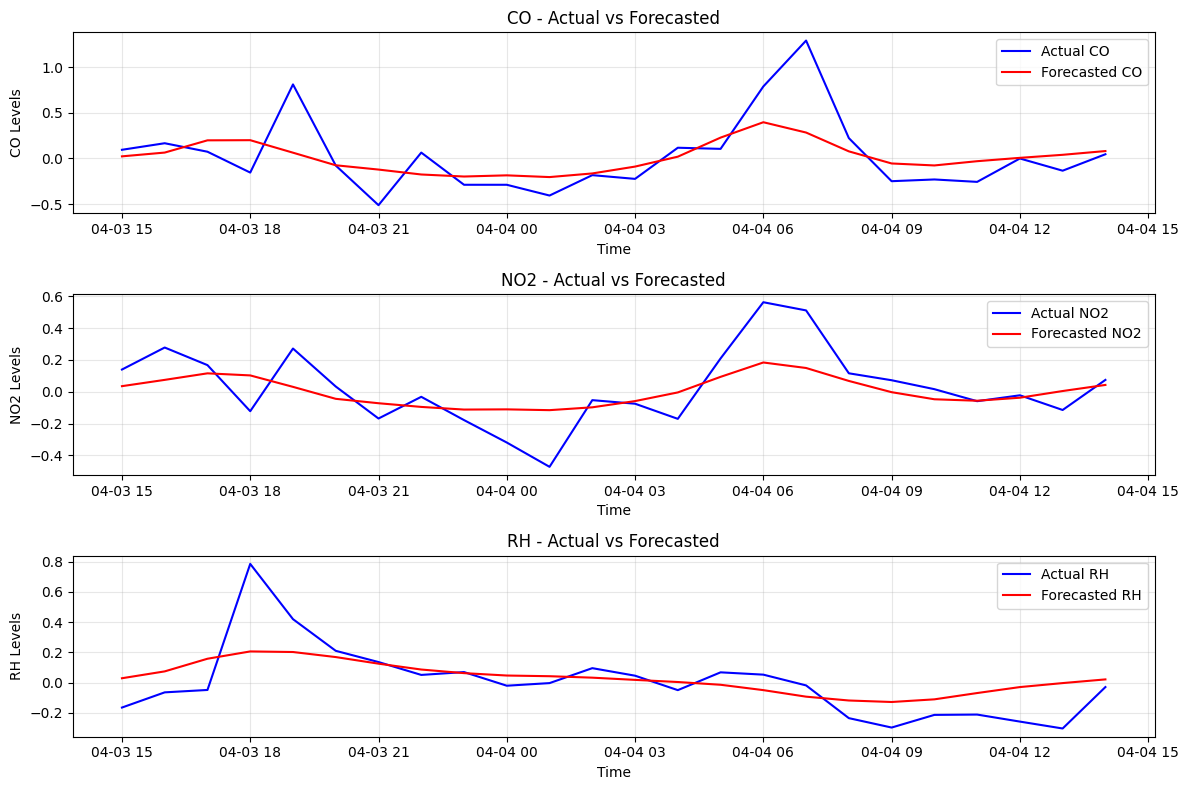

Evaluation Metrics for LSTM Model:

CO:
MAE: 0.2140
MSE: 0.0983
RMSE: 0.3136

NO2:
MAE: 0.1305
MSE: 0.0293
RMSE: 0.1711

RH:
MAE: 0.1274
MSE: 0.0308
RMSE: 0.1756


In [ ]:
# LSTM model

# 1. Prepare the Data
# Define training and test sets
train = df_log[:-24]  # All but the last 24 values for training
test = df_log[-24:]   # Last 24 values for testing

# Convert to numpy arrays
train_values = train.values
test_values = test.values

# Scale the data (LSTM performs better with normalized data)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.transform(test_values)

# Define a function to create time series generator
def create_generator(data, lookback, batch_size=1):
    generator = TimeseriesGenerator(data, data, length=lookback, batch_size=batch_size)
    return generator

lookback = 12  # Number of previous time steps to use
batch_size = 1

# Create data generators
train_generator = create_generator(train_scaled, lookback, batch_size)

# 2. Build the LSTM Model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(lookback, train_scaled.shape[1]), return_sequences=False),
    Dense(train_scaled.shape[1])  # Predict all variables at once
])

model.compile(optimizer='adam', loss='mse')

# 3. Train the Model
epochs = 20
history = model.fit(train_generator, epochs=epochs, verbose=1)

# 4. Forecast the Next 24 Data Points
forecast = []
current_batch = train_scaled[-lookback:].reshape(1, lookback, train_scaled.shape[1])

for i in range(24):  # Predict the next 24 steps
    # Get the prediction
    predicted = model.predict(current_batch, verbose=0)
    forecast.append(predicted[0])
    
    # Update the current batch with the new prediction
    predicted_reshaped = predicted.reshape(1, 1, -1)  # Reshape predicted to match (1, 1, features)
    current_batch = np.append(current_batch[:, 1:, :], predicted_reshaped, axis=1)


# Inverse transform the forecast back to original scale
forecast_scaled = np.array(forecast)
forecast_original = scaler.inverse_transform(forecast_scaled)

# Convert to DataFrame for easy comparison
forecast_df = pd.DataFrame(forecast_original, index=test.index, columns=df_log.columns)

# 5. Plot Actual vs Forecasted
fig, axes = plt.subplots(len(df_log.columns), 1, figsize=(12, 8))
for i, col in enumerate(df_log.columns):
    axes[i].plot(test.index, test[col], label=f'Actual {col}', color='blue')
    axes[i].plot(forecast_df.index, forecast_df[col], label=f'Forecasted {col}', color='red')
    axes[i].set_title(f'{col} - Actual vs Forecasted')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(f'{col} Levels')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Evaluate Performance (MAE, MSE, RMSE)
metrics = {}
for col in df_log.columns:
    mae = mean_absolute_error(test[col], forecast_df[col])
    mse = mean_squared_error(test[col], forecast_df[col])
    rmse = np.sqrt(mse)
    metrics[col] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

# Print evaluation metrics
print("Evaluation Metrics for LSTM Model:")
for col, metric in metrics.items():
    print(f"\n{col}:")
    print(f"MAE: {metric['MAE']:.4f}")
    print(f"MSE: {metric['MSE']:.4f}")
    print(f"RMSE: {metric['RMSE']:.4f}")
